## Cosinor Regression Model for "Episode Analysis"
This is the Cosinor Regression model used for the new sample datasets that contain the daily episode of TR-PTSD symptoms.

### SetUp

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy.ma import add

from CosinorPy import file_parser, cosinor, cosinor1
np.seterr(divide='ignore')
import scipy.signal as signal
import scipy.stats as stats
import matplotlib.pyplot as plt
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.multitest as multi
from scipy.optimize import curve_fit
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from scipy.stats import percentileofscore
from scipy.stats import circstd, circmean

import seaborn as sns

import copy
import itertools
from matplotlib.lines import Line2D
from random import sample

import os

import copy

from CosinorPy.helpers import df_add_row

### Data Cleaning for Cosinor Model Use

In [4]:
def load_data(path):
    """Function used to parser the data using the file_parser method from the CosinorPy package"""
    df = pd.read_csv(path)
    df['Region start time'] = pd.to_datetime(df['Region start time'])
    df['date'] = df['Region start time'].dt.date
    df['hour'] = df['Region start time'].dt.hour
    df = df.drop('Unnamed: 0', axis=1)
    print(df)
    return df

def to_matrix(df, event_col, min_valid_hours = 12):
    # Pivot to days x hours
    matrix = df.pivot(index='date', columns='hour', values=event_col)
    matrix = matrix.interpolate(axis=1, limit_direction='both')
    matrix = matrix[matrix.count(axis=1) >= min_valid_hours]
    matrix = matrix.fillna(0)
    print(matrix)
    return matrix

In [5]:
pre_data = load_data("data/RNS_G_Pre_output.csv")
post_data = load_data("data/RNS_G_M1_output.csv")

      Region start time  Pattern A Channel 2  Episode starts with RX  \
0   2024-11-19 10:00:00                    0                       0   
1   2024-11-19 11:00:00                   19                       0   
2   2024-11-19 12:00:00                   38                       0   
3   2024-11-19 13:00:00                    1                       0   
4   2024-11-19 14:00:00                    3                       0   
..                  ...                  ...                     ...   
705 2024-12-18 19:00:00                   40                       0   
706 2024-12-18 20:00:00                   68                       0   
707 2024-12-18 21:00:00                   87                       0   
708 2024-12-18 22:00:00                   77                       0   
709 2024-12-18 23:00:00                   15                       0   

           date  hour  
0    2024-11-19    10  
1    2024-11-19    11  
2    2024-11-19    12  
3    2024-11-19    13  
4    2024-11-19

In [6]:
pre_matrix = to_matrix(pre_data, "Pattern A Channel 2")
post_matrix = to_matrix(post_data, "Pattern A Channel 2")

hour           0      1      2      3      4      5      6      7      8   \
date                                                                        
2024-11-19    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
2024-11-20    9.0    9.0   20.0   57.0   25.0   35.0   37.0   58.0   40.0   
2024-11-21   34.0   19.0   12.0   17.0   34.0   49.0   41.0   43.0   32.0   
2024-11-22    1.0   14.0    1.0    7.0  251.0  153.0  254.0   39.0  235.0   
2024-11-23    0.0    0.0   57.0    1.0  199.0  254.0   56.0  174.0  112.0   
2024-11-24    0.0   58.0  254.0    0.0    0.0  202.0  254.0   64.0   15.0   
2024-11-25   86.0  254.0   35.0   36.0  185.0   49.0   21.0  109.0    5.0   
2024-11-26    1.0  230.0  136.0    0.0  254.0  146.0    1.0    0.0    0.0   
2024-11-27    0.0   18.0   71.0  105.0   26.0   83.0    0.0   71.0   12.0   
2024-11-28    0.0   27.0   70.0   81.0   18.0  122.0   37.0    0.0    0.0   
2024-11-29    0.0   29.0   50.0   37.0    4.0    4.0   13.0   22.0    3.0   

## Cosinor Model Analysis 

The pseudo-algorithm for Cosinor Regression Model analysis extracted from CosinorPy. Some adjustments were taken for adaptation of the data.

### Cosinor Model Analysis - Overview Setting

This setting has the following features:   
    1. Date and time was combined using the format of decimals: specific hours were converted into decimal places of the given days
    2. The combined timeline is the x-axis and the test data (Pattern A Channel 2 or Episode starts with RX) is the y-axis

#### Function definition

In [16]:
def cosinor_regression1(df):
    """Basic Cosinor Regression Model used for the episode data (Pattern A Channel 2), normalizing time into a consecutive arithmetic timestamp."""
    df1 = df.copy()
    df1["test"] = df1["Pattern A Channel 2"]
    df1["x"] = df1["Region start time"]  # use this datetime field
    df1["y"] = df1["date"]

    # Convert Region start time to fractional days since first timepoint
    df1["x"] = pd.to_datetime(df1["x"])  # ensure proper datetime format
    t0 = df1["x"].min()
    df1["x"] = df1["x"].apply(lambda t: (t - t0).total_seconds() / (24 * 3600))  # days as float

    # Optional: Convert y to numeric if needed
    df1["y"] = df1["y"].apply(lambda x: x.toordinal() if hasattr(x, "toordinal") else x)

    df1 = df1.drop(["Region start time", "Pattern A Channel 2", "Episode starts with RX", "date", "hour"], axis=1)
    print(df1)

    cosinor.fit_me(df1["x"], df1["test"])

def cosinor_regression2(df):
    """Basic Cosinor Regression Model used for the episode data (Episode starts with RX), normalizing time into a consecutive arithmetic timestamp."""
    df1 = df.copy()
    df1["test"] = df1["Episode starts with RX"]
    df1["x"] = df1["Region start time"]  # use this datetime field
    df1["y"] = df1["date"]

    # Convert Region start time to fractional days since first timepoint
    df1["x"] = pd.to_datetime(df1["x"])  # ensure proper datetime format
    t0 = df1["x"].min()
    df1["x"] = df1["x"].apply(lambda t: (t - t0).total_seconds() / (24 * 3600))  # days as float

    # Optional: Convert y to numeric if needed
    df1["y"] = df1["y"].apply(lambda x: x.toordinal() if hasattr(x, "toordinal") else x)

    df1 = df1.drop(["Region start time", "Pattern A Channel 2", "Episode starts with RX", "date", "hour"], axis=1)
    print(df1)

    cosinor.fit_me(df1["x"], df1["test"])

#### Pre_data Analysis (Before Stimulus)

     test          x       y
0       0   0.000000  739209
1      19   0.041667  739209
2      38   0.083333  739209
3       1   0.125000  739209
4       3   0.166667  739209
..    ...        ...     ...
705    40  29.375000  739238
706    68  29.416667  739238
707    87  29.458333  739238
708    77  29.500000  739238
709    15  29.541667  739238

[710 rows x 3 columns]


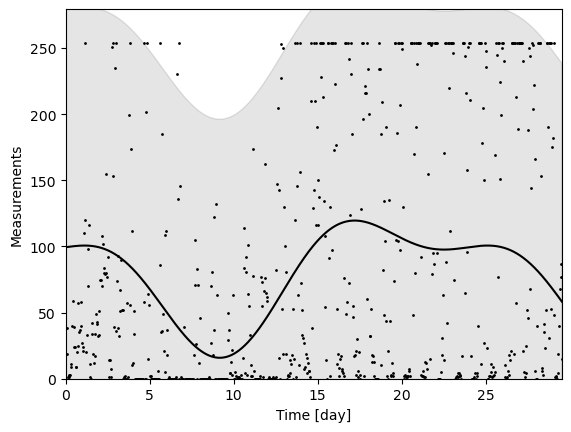

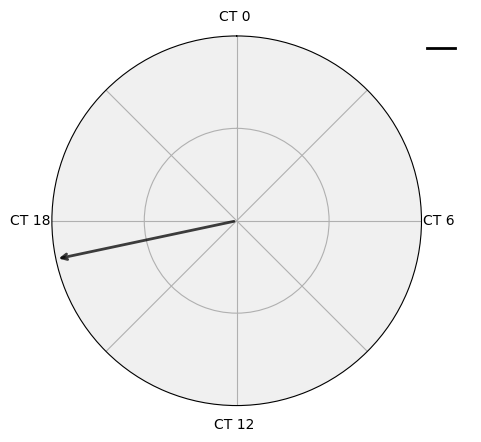

In [17]:
cosinor_regression1(pre_data)

#### Post_data Analysis (After Stimulus)

      Region start time  test          x       y
0   2024-12-19 16:00:00     8   0.000000  739239
1   2024-12-19 17:00:00     8   0.041667  739239
2   2024-12-19 18:00:00    19   0.083333  739239
3   2024-12-19 19:00:00    45   0.125000  739239
4   2024-12-19 20:00:00   123   0.166667  739239
..                  ...   ...        ...     ...
651 2025-01-15 19:00:00    92  27.125000  739266
652 2025-01-15 20:00:00   128  27.166667  739266
653 2025-01-15 21:00:00   162  27.208333  739266
654 2025-01-15 22:00:00    49  27.250000  739266
655 2025-01-15 23:00:00   101  27.291667  739266

[656 rows x 4 columns]


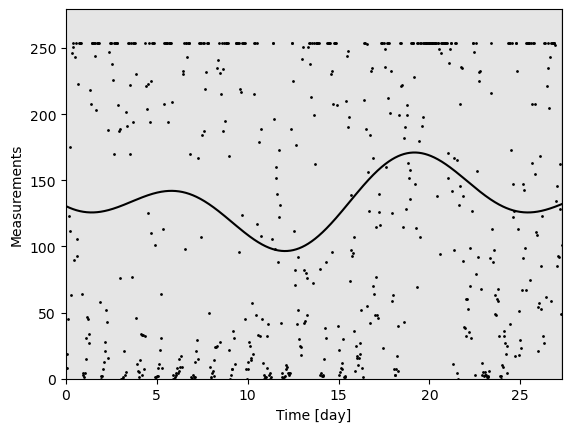

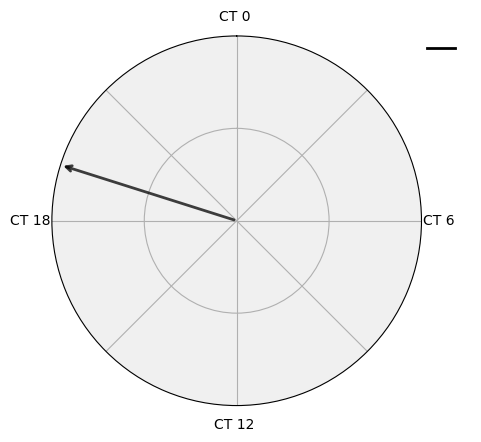

      Region start time  test          x       y
0   2024-12-19 16:00:00     5   0.000000  739239
1   2024-12-19 17:00:00     8   0.041667  739239
2   2024-12-19 18:00:00    19   0.083333  739239
3   2024-12-19 19:00:00    45   0.125000  739239
4   2024-12-19 20:00:00   123   0.166667  739239
..                  ...   ...        ...     ...
651 2025-01-15 19:00:00    93  27.125000  739266
652 2025-01-15 20:00:00   127  27.166667  739266
653 2025-01-15 21:00:00   163  27.208333  739266
654 2025-01-15 22:00:00    49  27.250000  739266
655 2025-01-15 23:00:00   101  27.291667  739266

[656 rows x 4 columns]


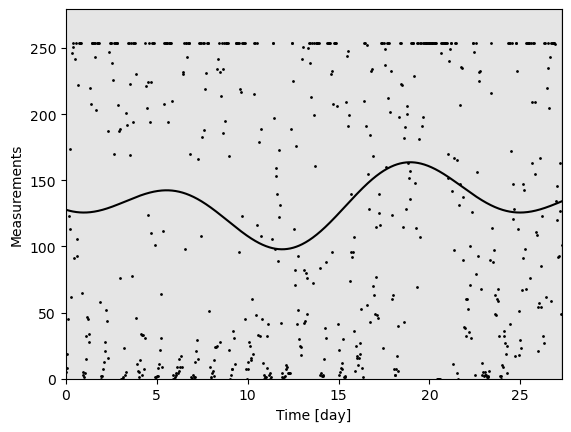

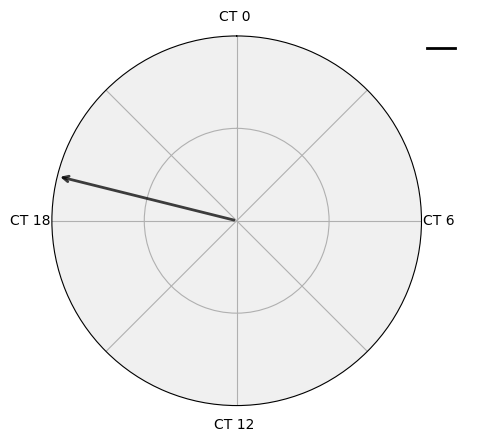

In [ ]:
cosinor_regression1(post_data)
cosinor_regression2(post_data)

#### Overall Analysis merging two datasets

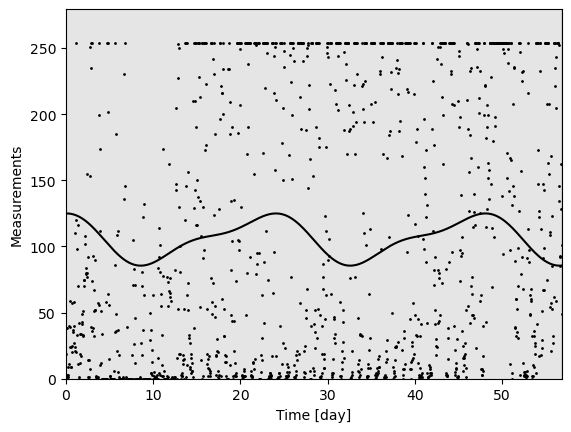

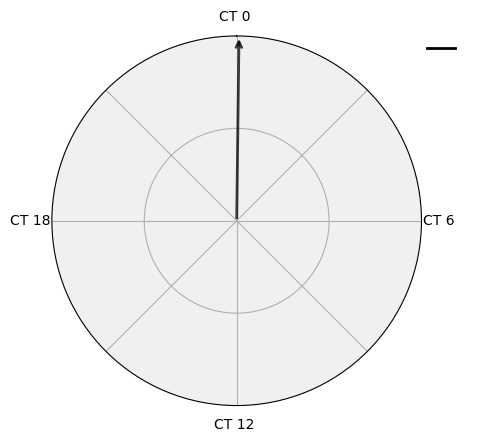

In [ ]:
def cosinor_both(df1, df2):
    """Concatenate two dataframes and fit a Cosinor regression model."""
    # df1 dataset cleaning and preparation
    df1_copy = df1.copy()
    df1_copy["test"] = df1_copy["Pattern A Channel 2"]
    df1_copy["x"] = df1_copy["Region start time"]  # use this datetime field
    df1_copy["y"] = df1_copy["date"]

    # Convert Region start time to fractional days since first timepoint
    df1_copy["x"] = pd.to_datetime(df1_copy["x"])  # ensure proper datetime format
    t0 = df1_copy["x"].min()
    df1_copy["x"] = df1_copy["x"].apply(lambda t: (t - t0).total_seconds() / (24 * 3600))  # days as float
    df1_copy["y"] = df1_copy["y"].apply(lambda x: x.toordinal() if hasattr(x, "toordinal") else x)

    df1_copy = df1_copy.drop(["Pattern A Channel 2", "Episode starts with RX", "date", "hour"], axis=1)
    
    x_shift = df1_copy["x"].max()

    # df2 dataset cleaning and preparation
    df2_copy = df2.copy()
    df2_copy["test"] = df2_copy["Pattern A Channel 2"]
    df2_copy["x"] = df2_copy["Region start time"]  # use this datetime field
    df2_copy["y"] = df2_copy["date"]

    # Convert Region start time to fractional days since first timepoint
    df2_copy["x"] = pd.to_datetime(df2_copy["x"])  # ensure proper datetime format
    t0 = df2_copy["x"].min()
    df2_copy["x"] = df2_copy["x"].apply(lambda t: (t - t0).total_seconds() / (24 * 3600))  # days as float
    df2_copy["y"] = df2_copy["y"].apply(lambda x: x.toordinal() if hasattr(x, "toordinal") else x)

    df2_copy = df2_copy.drop(["Pattern A Channel 2", "Episode starts with RX", "date", "hour"], axis=1)

    df2_copy["x"] += x_shift  # shift x-axis to be consecutive
    # Step 2: Concatenate
    df_full = pd.concat([df1_copy, df2_copy], ignore_index=True)
    # Step 3: Plot or fit
    cosinor.fit_me(df_full["x"], df_full["test"])

cosinor_both(pre_data, post_data)

### Cosinor Model Analysis - Specific Setting

This setting has the following features:    
    1. x-axis and y-axis are date and hour respectively    
    2. Data points lower than a specific "threshold" are removed

In [ ]:
def cosinor_regression_specific1(df1, df2):
    """
    The specfic Cosinor Regression Model used for the episode data (Pattern A Channel 2), normalizing time into a consecutive arithmetic timestamp.
    This function is similar to cosinor_regression1 but uses a specific standard to reduce the "noise" of the dataset.
    """
    df1_copy = df1.copy()
    # Filtering
    df1_clean = df1_copy[df1_copy["Pattern A Channel 2"] < 20]
    df1_clean = df1_clean[df1_clean["Pattern A Channel 2"] != 255]


    # Clean and prepare df1
    df1_clean["test"] = df1_clean["Pattern A Channel 2"]
    df1_clean["x"] = df1_clean["date"]  # use this datetime field
    df1_clean["y"] = df1_clean["hour"]

    # Convert Region start time to fractional days since first timepoint
    df1_clean["x"] = pd.to_datetime(df1_clean["x"])  # ensure proper datetime format
    t0 = df1_clean["x"].min()
    df1_clean["x"] = df1_clean["x"].apply(lambda t: (t - t0).total_seconds() / (24 * 3600))  # days as float
    df1_clean["y"] = df1_clean["y"].apply(lambda x: x.toordinal() if hasattr(x, "toordinal") else x)

    df1_clean = df1_clean.drop(["Pattern A Channel 2", "Episode starts with RX", "date", "hour"], axis=1)
    print(df1_clean)

    x_shift = df1_clean["x"].max()
    
    df2_copy = df2.copy()
    # Filtering
    df2_clean = df2_copy[df2_copy["Pattern A Channel 2"] < 20] 
    df2_clean = df2_clean[df2_clean["Pattern A Channel 2"] != 255]

    # Clean and prepare df2
    df2_clean["test"] = df2_clean["Pattern A Channel 2"]
    df2_clean["x"] = df2_clean["date"]  # use this datetime field
    df2_clean["y"] = df2_clean["hour"]
    
    df2_clean["x"] = pd.to_datetime(df2_clean["x"])  # ensure proper datetime format
    t0 = df2_clean["x"].min()
    df2_clean["x"] = df2_clean["x"].apply(lambda t: (t - t0).total_seconds() / (24 * 3600))  # days as float
    df2_clean["y"] = df2_clean["y"].apply(lambda x: x.toordinal() if hasattr(x, "toordinal") else x)

    df2_clean = df2_clean.drop(["Pattern A Channel 2", "Episode starts with RX", "date", "hour"], axis=1)

    # Final combination
    df2_clean["x"] += x_shift  # shift x-axis to be consecutive for plotting
    df_full = pd.concat([df1_clean, df2_clean], ignore_index=True)
    

    cosinor.fit_me(df_full["x"], df_full["test"])


      Region start time  test     x   y
0   2024-11-19 10:00:00     0   0.0  10
1   2024-11-19 11:00:00    19   0.0  11
3   2024-11-19 13:00:00     1   0.0  13
4   2024-11-19 14:00:00     3   0.0  14
5   2024-11-19 15:00:00     1   0.0  15
..                  ...   ...   ...  ..
701 2024-12-18 15:00:00     2  29.0  15
702 2024-12-18 16:00:00     0  29.0  16
703 2024-12-18 17:00:00     4  29.0  17
704 2024-12-18 18:00:00    19  29.0  18
709 2024-12-18 23:00:00    15  29.0  23

[324 rows x 4 columns]


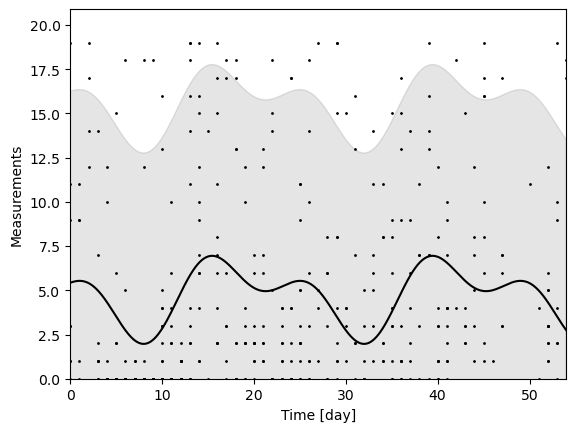

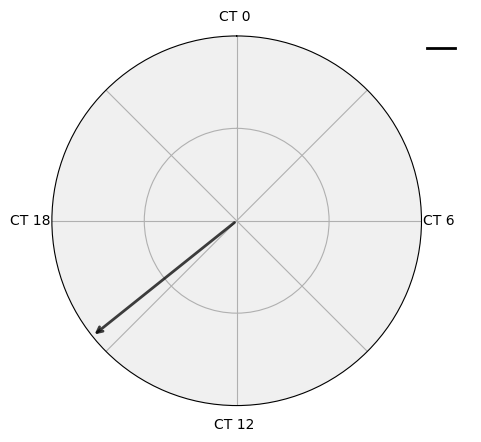

In [ ]:
cosinor_regression_specific1(pre_data, post_data)

### Counting Method

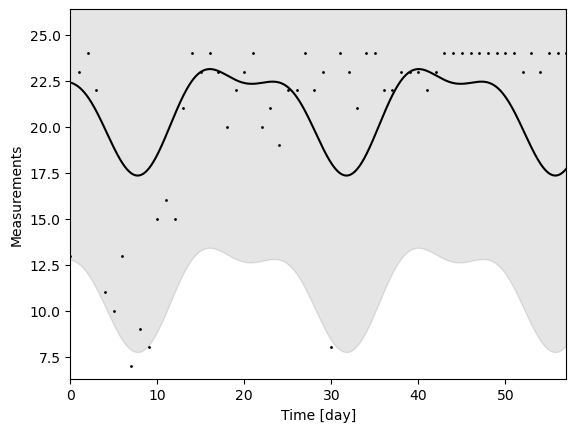

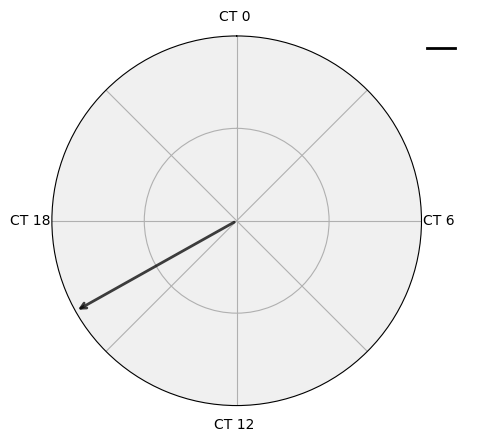

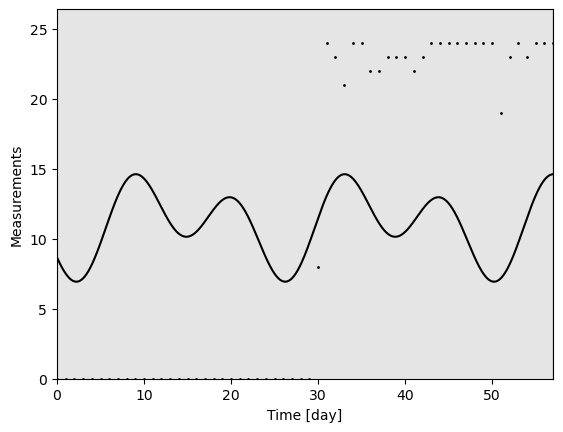

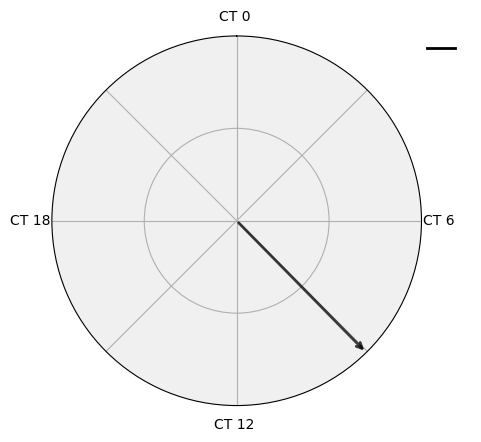

In [ ]:
def cosinor_count_both_patternA(df1, df2):
    """Concatenate two dataframes and fit a Cosinor regression model for everyday count of the episodes."""
    df1_copy = df1.copy()
    df2_copy = df2.copy()

    # Combine the two dataframes
    df_combined = pd.concat([df1_copy, df2_copy], ignore_index=True)

    # Ensure datetime format
    df_combined['date'] = pd.to_datetime(df_combined['date'])

    # Extract date (without time) and assign it back
    df_combined['day'] = df_combined['date'].dt.date

    # Group by day and count non-zero "Pattern A Channel 2" values
    grouped = df_combined.groupby('day')["Pattern A Channel 2"].apply(lambda x: (x != 0).sum()).reset_index()

    # Rename columns
    grouped.columns = ['day', 'non_zero_count']

    # Convert day to consecutive integers starting from 0
    grouped['x'] = (pd.to_datetime(grouped['day']) - pd.to_datetime(grouped['day']).min()).dt.days

    cosinor.fit_me(grouped["x"], grouped["non_zero_count"])

cosinor_count_both_patternA(pre_data, post_data)

def cosinor_count_both_EpisodeRX(df1, df2):
    """Concatenate two dataframes and fit a Cosinor regression model for everyday count of the episodes."""
    df1_copy = df1.copy()
    df2_copy = df2.copy()

    # Combine the two dataframes
    df_combined = pd.concat([df1_copy, df2_copy], ignore_index=True)

    # Ensure datetime format
    df_combined['date'] = pd.to_datetime(df_combined['date'])

    # Extract date (without time) and assign it back
    df_combined['day'] = df_combined['date'].dt.date

    # Group by day and count non-zero "Pattern A Channel 2" values
    grouped = df_combined.groupby('day')["Episode starts with RX"].apply(lambda x: (x != 0).sum()).reset_index()

    # Rename columns
    grouped.columns = ['day', 'non_zero_count']

    # Convert day to consecutive integers starting from 0
    grouped['x'] = (pd.to_datetime(grouped['day']) - pd.to_datetime(grouped['day']).min()).dt.days

    cosinor.fit_me(grouped["x"], grouped["non_zero_count"])

cosinor_count_both_EpisodeRX(pre_data, post_data)

### Model 4

### Plots and Analysis